# Exercise - Black's Formula for Options on Futures

#### Notation Commands

$$\newcommand{\Black}{\mathcal{B}}
\newcommand{\Blackcall}{\Black_{\mathrm{call}}}
\newcommand{\Blackput}{\Black_{\mathrm{put}}}
\newcommand{\EcondS}{\hat{S}_{\mathrm{conditional}}}
\newcommand{\Efwd}{\mathbb{E}^{T}}
\newcommand{\Ern}{\mathbb{E}^{\mathbb{Q}}}
\newcommand{\Tfwd}{T_{\mathrm{fwd}}}
\newcommand{\Tunder}{T_{\mathrm{bond}}}
\newcommand{\accint}{A}
\newcommand{\carry}{\widetilde{\cpn}}
\newcommand{\cashflow}{C}
\newcommand{\convert}{\phi}
\newcommand{\cpn}{c}
\newcommand{\ctd}{\mathrm{CTD}}
\newcommand{\disc}{Z}
\newcommand{\done}{d_{1}}
\newcommand{\dt}{\Delta t}
\newcommand{\dtwo}{d_{2}}
\newcommand{\flatvol}{\sigma_{\mathrm{flat}}}
\newcommand{\flatvolT}{\sigma_{\mathrm{flat},T}}
\newcommand{\float}{\mathrm{flt}}
\newcommand{\freq}{m}
\newcommand{\futprice}{\mathcal{F}(t,T)}
\newcommand{\futpriceDT}{\mathcal{F}(t+h,T)}
\newcommand{\futpriceT}{\mathcal{F}(T,T)}
\newcommand{\futrate}{\mathscr{f}}
\newcommand{\fwdprice}{F(t,T)}
\newcommand{\fwdpriceDT}{F(t+h,T)}
\newcommand{\fwdpriceT}{F(T,T)}
\newcommand{\fwdrate}{f}
\newcommand{\fwdvol}{\sigma_{\mathrm{fwd}}}
\newcommand{\fwdvolTi}{\sigma_{\mathrm{fwd},T_i}}
\newcommand{\grossbasis}{B}
\newcommand{\hedge}{\Delta}
\newcommand{\ivol}{\sigma_{\mathrm{imp}}}
\newcommand{\logprice}{p}
\newcommand{\logyield}{y}
\newcommand{\mat}{(n)}
\newcommand{\nargcond}{d_{1}}
\newcommand{\nargexer}{d_{2}}
\newcommand{\netbasis}{\tilde{\grossbasis}}
\newcommand{\normcdf}{\mathcal{N}}
\newcommand{\notional}{K}
\newcommand{\pfwd}{P_{\mathrm{fwd}}}
\newcommand{\pnl}{\Pi}
\newcommand{\price}{P}
\newcommand{\probexer}{\hat{\mathcal{P}}_{\mathrm{exercise}}}
\newcommand{\pvstrike}{K^*}
\newcommand{\refrate}{r^{\mathrm{ref}}}
\newcommand{\rrepo}{r^{\mathrm{repo}}}
\newcommand{\spotrate}{r}
\newcommand{\spread}{s}
\newcommand{\strike}{K}
\newcommand{\swap}{\mathrm{sw}}
\newcommand{\swaprate}{\cpn_{\swap}}
\newcommand{\tbond}{\mathrm{fix}}
\newcommand{\ttm}{\tau}
\newcommand{\value}{V}
\newcommand{\vega}{\nu}
\newcommand{\years}{\tau}
\newcommand{\yearsACT}{\tau_{\mathrm{act/360}}}
\newcommand{\yield}{Y}$$

### Data

In this exercise, we use Black's formula to price options on futures contracts.
* `option_data_bb_SFRZ5.xlsx` - market data on SOFR 3-month futures, and its option chain.

# 1. SOFR Futures Options

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [2]:
FILEDATA = "data/option_data_bb_SFRZ5.xlsx"
SHEETNAME = 'spot'
spot = pd.read_excel(FILEDATA, sheet_name=SHEETNAME).rename(columns={'Unnamed: 0': 'field'}).set_index('field')
display(spot)

,SFRZ5 Comdty
field,
name,3 MONTH SOFR FUT Dec25
last update date,1969-12-31 18:00:45.867000
last update time,10:03:48
price,96.085
hist vol 30d,0.006851
hist vol 60d,0.007595
volume,150071


In [3]:
EXPRY_CHAIN_LOC = 1
SHEETNAME = pd.ExcelFile(FILEDATA).sheet_names[EXPRY_CHAIN_LOC]
options = pd.read_excel(FILEDATA, sheet_name=SHEETNAME).set_index('ticker')
display(options.loc[options['option type'].str.contains('C')])
display(options.loc[options['option type'].str.contains('P')])

,last update date,last update time,days to expiration,option type,exercise style,option contract size,strike price,price,finance rate,time value,...,delta,gamma,vega,theta,bid,ask,bid size,ask size,open int,volume
ticker,,,,,,,,,,,,,,,,,,,,,
SFRV5C 95.75 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,C,AMER,2500,95.7500,0.3300,0.04396,-0.0050,...,0.899011,0.028984,0.002962,-0.000265,0.3350,0.350,51,51,10703,NaN
SFRV5C 95.8125 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,C,AMER,2500,95.8125,0.2775,0.04396,0.0050,...,0.847946,0.037543,0.003990,-0.000369,0.2850,0.295,120,333,0,NaN
SFRV5C 95.875 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,C,AMER,2500,95.8750,0.2325,0.04396,0.0225,...,0.768768,0.045176,0.005212,-0.000524,0.2350,0.245,14976,119,20020,NaN
SFRV5C 95.9375 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,C,AMER,2500,95.9375,0.1950,0.04396,0.0475,...,0.679044,0.049114,0.006161,-0.000676,0.1950,0.205,15838,248,7013,NaN
SFRV5C 96 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,C,AMER,2500,96.0000,0.1600,0.04396,0.0750,...,0.589523,0.049138,0.006712,-0.000805,0.1600,0.175,7500,19302,15635,NaN
SFRV5C 96.0625 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,C,AMER,2500,96.0625,0.1300,0.04396,0.1075,...,0.506743,0.047811,0.006902,-0.000892,0.1350,0.145,100,36274,31106,3882.0
SFRV5C 96.125 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,C,AMER,2500,96.1250,0.1050,0.04396,0.1050,...,0.430860,0.046676,0.006811,-0.000887,0.1050,0.115,37066,8327,43461,2500.0
SFRV5C 96.1875 Comdty,1969-12-31 18:00:45.867,08:33:45,73,C,AMER,2500,96.1875,0.0850,0.04396,0.0850,...,0.360056,0.043005,0.006494,-0.000875,0.0800,0.095,56885,48479,76938,2698.0
SFRV5C 96.25 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,C,AMER,2500,96.2500,0.0675,0.04396,0.0675,...,0.297882,0.038291,0.006022,-0.000844,0.0650,0.075,46199,27485,72563,9950.0


,last update date,last update time,days to expiration,option type,exercise style,option contract size,strike price,price,finance rate,time value,...,delta,gamma,vega,theta,bid,ask,bid size,ask size,open int,volume
ticker,,,,,,,,,,,,,,,,,,,,,
SFRV5P 95.75 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,P,AMER,2500,95.7500,0.0075,0.04396,0.0075,...,-0.076812,0.025414,0.002511,-0.000220,0.0050,0.010,25297,11208,57342,2550.0
SFRV5P 95.8125 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,P,AMER,2500,95.8125,0.0175,0.04396,0.0175,...,-0.138375,0.036404,0.003844,-0.000361,0.0125,0.020,50328,39390,18597,NaN
SFRV5P 95.875 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,P,AMER,2500,95.8750,0.0350,0.04396,0.0350,...,-0.219462,0.045113,0.005143,-0.000522,0.0275,0.035,40887,8311,50736,5225.0
SFRV5P 95.9375 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,P,AMER,2500,95.9375,0.0575,0.04396,0.0575,...,-0.313520,0.049041,0.006158,-0.000689,0.0500,0.060,33397,49762,18828,NaN
SFRV5P 96 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,P,AMER,2500,96.0000,0.0850,0.04396,0.0850,...,-0.398240,0.051125,0.006694,-0.000782,0.0750,0.085,53974,758,62162,1000.0
SFRV5P 96.0625 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,P,AMER,2500,96.0625,0.1175,0.04396,0.1175,...,-0.483743,0.048766,0.006901,-0.000871,0.1100,0.120,1197,40350,11505,3286.0
SFRV5P 96.125 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,P,AMER,2500,96.1250,0.1550,0.04396,0.1150,...,-0.560378,0.046505,0.006812,-0.000895,0.1450,0.155,867,34387,63551,NaN
SFRV5P 96.1875 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,P,AMER,2500,96.1875,0.1950,0.04396,0.0925,...,-0.634074,0.043781,0.006484,-0.000842,0.1850,0.195,353,22485,14955,NaN
SFRV5P 96.25 Comdty,1969-12-31 18:00:45.866,1969-12-31 18:00:45.866000,73,P,AMER,2500,96.2500,0.2425,0.04396,0.0775,...,-0.698355,0.038957,0.005992,-0.000807,0.2300,0.240,238,17500,13145,NaN


### 1.1.

Use Black's Formula to price the **call option**
* at the nearest expiration
* using the ATM strike (strike nearest the spot)
* using the implied vol provided in the data
* using the finance rate as the discount rate

How close is your estimate to the market quote?

In [4]:
call_options = options.loc[(options['option type'].str.contains('C'))]
call_options_closest_to_exp = call_options.loc[(call_options['days to expiration'] == call_options['days to expiration'].min())]

# Fut price
spot_fut_price = spot.loc['price', 'SFRZ5 Comdty']

nearest_to_spot = call_options.loc[(call_options['strike price'] - spot_fut_price).abs().idxmin()]

print(nearest_to_spot)

last update date        1969-12-31 18:00:45.866000
last update time        1969-12-31 18:00:45.866000
days to expiration                              73
option type                                      C
exercise style                                AMER
option contract size                          2500
strike price                               96.0625
price                                         0.13
finance rate                               0.04396
time value                                  0.1075
implied vol                               0.185438
delta                                     0.506743
gamma                                     0.047811
vega                                      0.006902
theta                                    -0.000892
bid                                          0.135
ask                                          0.145
bid size                                       100
ask size                                     36274
open int                       

### Discussion

The quoted volatility in the option chain is the **Yield Volatility** (volatility of the interest rate), but we need **Price Volatility** (volatility of the futures price) to compute option price using Black's formula.

Because Black's model (Black-76) for futures options takes the **Futures Price** as the underlying asset, you must feed it the volatility of that price, not the volatility of the interest rate.

The formula shown below is a conversion between **Yield Volatility** and **Price Volatility**.

#### The Derivation
To understand the math, we have to look at how Short-Term Interest Rate (STIR) futures are quoted.

**1. The Relationship between Price and Rate**

   STIR futures (like Eurodollar or SOFR futures) are quoted as an index:$$F = 100 - R$$

   Where:
   - $F$ is the Futures Price (the ```fwd``` variable in your code).
   - $R$ is the Interest Rate (the ```100 - fwd``` part of your code).

**2. Absolute Moves are Identical**

   If the interest rate moves by 1 basis point (0.01), the futures price moves by 1 tick (0.01). The magnitude of the change is the same, just in opposite directions:$$\Delta F = - \Delta R$$Therefore, the standard deviation of the absolute changes is equal:$$\text{StdDev}(\Delta F) = \text{StdDev}(\Delta R)$$

**3. Lognormal Volatility (The Conversion)**

   Black's volatility is a percentage (relative) measure. It looks at the change relative to the current level.
   - Price Volatility ($\sigma_F$): $\frac{\Delta F}{F}$
   - Yield Volatility ($\sigma_R$): $\frac{\Delta R}{R}$

   We can express the absolute standard deviation in terms of these volatilities:$$\text{StdDev}(\Delta F) = \sigma_F \times F$$$$\text{StdDev}(\Delta R) = \sigma_R \times R$$Since the absolute changes are equal (step 2), we can equate these two:$$\sigma_F \times F = \sigma_R \times R$$

**4. Solving for Price Volatility**

   Now, we just rearrange the equation to solve for $\sigma_F$ (the price volatility needed for the Black model):$$\sigma_F = \sigma_R \times \frac{R}{F}$$Substitute $R = 100 - F$ back into the equation:$$\sigma_F = \sigma_R \times \frac{100 - F}{F}$$

#### Mapping to Your Code
- $\sigma_F$ is your ```Price Vol```
- $\sigma_R$ is your ```Yield Vol```
- $R$ is ```(100 - fwd)```
- $F$ is ```fwd```$$\text
{Price Vol} = \text{Yield Vol} \times \frac{100 - \text{fwd}}{\text{fwd}}$$

In [5]:
def calculate_black_price(spot_fut_price, row):

    implied_vol = row.loc['implied vol'] * (100 - spot_fut_price) / spot_fut_price
    discount_rate = row.loc['finance rate']
    strike = row.loc['strike price']
    time_to_expiry = row.loc['days to expiration'] / 365

    discount_factor = np.exp(-discount_rate * time_to_expiry)

    # Blacks formula
    d1 = (np.log(spot_fut_price / strike) + (0.5 * np.pow(implied_vol, 2) * time_to_expiry)) / (implied_vol * np.sqrt(time_to_expiry))
    d2 = d1 - (implied_vol * np.sqrt(time_to_expiry))

    option_price = discount_factor * (spot_fut_price * norm.cdf(d1) - strike * norm.cdf(d2))
    return option_price

quoted_last_option_price = nearest_to_spot.loc['price']
quoted_mid_option_price = (nearest_to_spot.loc['bid'] + nearest_to_spot.loc['ask']) / 2
nearest_to_spot_option_price = calculate_black_price(spot_fut_price, nearest_to_spot)

print(f"Quoted last traded option price = {quoted_last_option_price}")
print(f"Quoted mid option price = {quoted_mid_option_price}")
print(f"Calculated option price using Black's formula = {nearest_to_spot_option_price:.4f}")
print(f"Difference from last = {quoted_last_option_price - nearest_to_spot_option_price:.4f}")
print(f"Difference from mid = {quoted_mid_option_price - nearest_to_spot_option_price:.4f}")

Quoted last traded option price = 0.13
Quoted mid option price = 0.14
Calculated option price using Black's formula = 0.1398
Difference from last = -0.0098
Difference from mid = 0.0002


### 1.2.

Value the entire strike chain for the nearest expiration.
* Use the provided implied vol for each strike.

Plot the Black values against the market values.

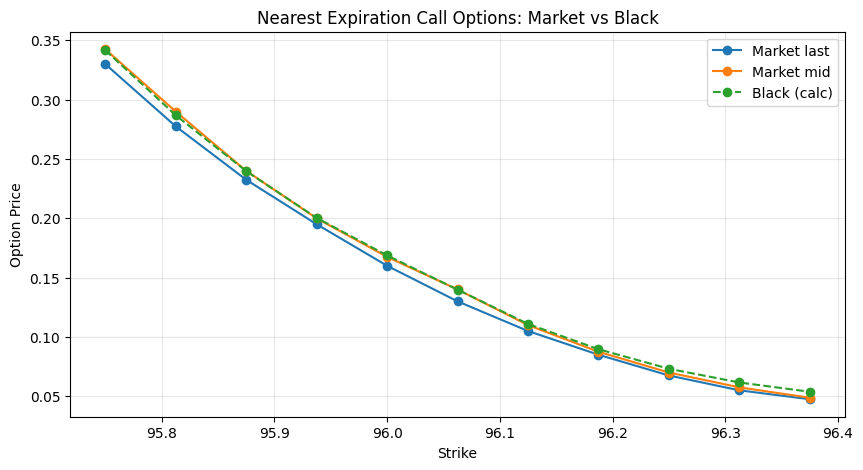

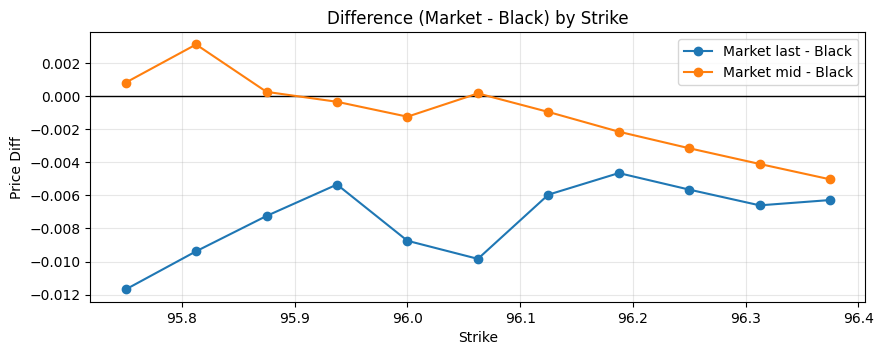

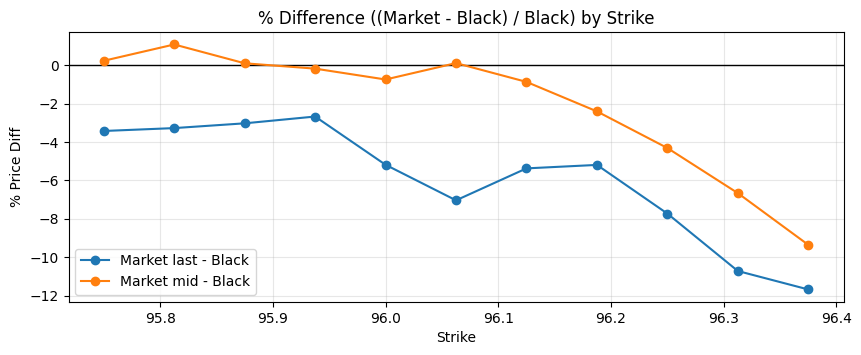

In [6]:
call_options_closest_to_exp['calc_price'] = call_options_closest_to_exp.apply(lambda row: calculate_black_price(spot_fut_price, row), axis=1)

# plot calc_price and price

# Work on a copy to avoid SettingWithCopyWarning and keep only needed columns
df_plot = (
    call_options_closest_to_exp.copy()
    .loc[:, ['strike price', 'price', 'bid', 'ask', 'calc_price']]
    .dropna(subset=['strike price', 'price', 'bid', 'ask', 'calc_price'])
    .sort_values('strike price')
)

# Line plot: Market vs Black
fig, ax = plt.subplots(figsize=(10, 5))

last = df_plot['price']
ax.plot(df_plot['strike price'], last, marker='o', linestyle='-', label='Market last')

mid = (df_plot['bid'] + df_plot['ask']) / 2
ax.plot(df_plot['strike price'], mid, marker='o', linestyle='-', label='Market mid')

ax.plot(df_plot['strike price'], df_plot['calc_price'], marker='o', linestyle='--', label='Black (calc)')

ax.set_title('Nearest Expiration Call Options: Market vs Black')
ax.set_xlabel('Strike')
ax.set_ylabel('Option Price')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# difference plot (Market - Black)
fig, ax = plt.subplots(figsize=(10, 3.5))

ax.axhline(0.0, color='black', linewidth=1)

diff_last = last - df_plot['calc_price']
ax.plot(df_plot['strike price'], diff_last, marker='o', linestyle='-', label='Market last - Black')

diff_mid = mid - df_plot['calc_price']
ax.plot(df_plot['strike price'], diff_mid, marker='o', linestyle='-', label='Market mid - Black')

ax.set_title('Difference (Market - Black) by Strike')
ax.set_xlabel('Strike')
ax.set_ylabel('Price Diff')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# % difference plot (Market - Black)
fig, ax = plt.subplots(figsize=(10, 3.5))

ax.axhline(0.0, color='black', linewidth=1)

per_diff_last = (diff_last / df_plot['calc_price']) * 100
ax.plot(df_plot['strike price'], per_diff_last, marker='o', linestyle='-', label='Market last - Black')

per_diff_mid = (diff_mid / df_plot['calc_price']) * 100
ax.plot(df_plot['strike price'], per_diff_mid, marker='o', linestyle='-', label='Market mid - Black')

ax.set_title('% Difference ((Market - Black) / Black) by Strike')
ax.set_xlabel('Strike')
ax.set_ylabel('% Price Diff')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

### 1.3. 

What are a few reasons that Black's value doesn't match the market value?

How significant is the American nature of the exercise?

### Discussion

- The option is not a recent issue and hence not traded as frequently (although there is sufficient open interest because of positions held).
- Hence, Market last trade prices are stale.
- Market-makers providing liquidity update the bid and ask price.
- Hence, Market mid prices are closer to calculated Black's price.
- The option being discussed here is an American option, which leads to difference in prices calculated using black's formula.
- American options provide greater exercise facility and should be priced higher than an European option with similar characteristics.
- American nature of the exercise is not significant as the market price is not consistently higher than the price calculated using blacks formula which assumes European exercise at maturity.

### 1.4.

How is implied vol being quoted? As in, does it reflect units of vol of percent changes in the SOFR rate? Or day-over-day differences? Or something else?

Use the data in `ref_rates.xlsx` to calculate the historic 60-day rolling volatility of the SOFR rate.

### Discussion

To compute volatility for SOFR (Secured Overnight Financing Rate), you have to account for the fact that it is an interest rate, not a stock price. While stock volatility is usually calculated on log returns, interest rate volatility is often calculated using **absolute basis point changes (Normal/Bachelier model)** or **relative changes (Lognormal/Black model)**.

Because SOFR can be very low (near zero), the financial industry often prefers Normal Volatility (basis point vol) over Lognormal Volatility to avoid issues with dividing by zero or getting skewed results at low levels.
- Normal (Bachelier) Vol: $\Delta R_t = R_t - R_{t-1}$
- Lognormal (Black) Vol: $r_t = \ln(R_t / R_{t-1})$

Since the interest rate options are typically quoted in terms of implied vol of the interest rate used in BS formula, the implied vol provided in the data reflects the volatility of the SOFR rate itself under a Lognormal assumption, rather than the volatility of the futures price.

In [7]:
hist_sofr_rates = pd.read_excel(r'data/ref_rates.xlsx', sheet_name='data')[['date','SOFR']]
hist_sofr_rates['date'] = pd.to_datetime(hist_sofr_rates['date'])

hist_sofr_rates['SOFR_FFILL_DAILY'] = (hist_sofr_rates['SOFR'].ffill() / 360) / 100
hist_sofr_rates = hist_sofr_rates.dropna(subset=['SOFR'])

In [8]:
def calculate_compounded_rate(period_end):
    period_start = period_end - pd.Timedelta(days=90)  # 90-day period

    actual_rates_period = hist_sofr_rates[(hist_sofr_rates['date'] >= period_start) & (hist_sofr_rates['date'] <= period_end)]
    if actual_rates_period.empty:
        return np.nan
    elif period_end > hist_sofr_rates['date'].max():
        return np.nan

    compounded_rate = 100 * (((1 + actual_rates_period['SOFR_FFILL_DAILY']).prod() - 1) * 360 / len(actual_rates_period))
    return compounded_rate

hist_sofr_rates['3M_SOFR'] = hist_sofr_rates['date'].apply(calculate_compounded_rate)

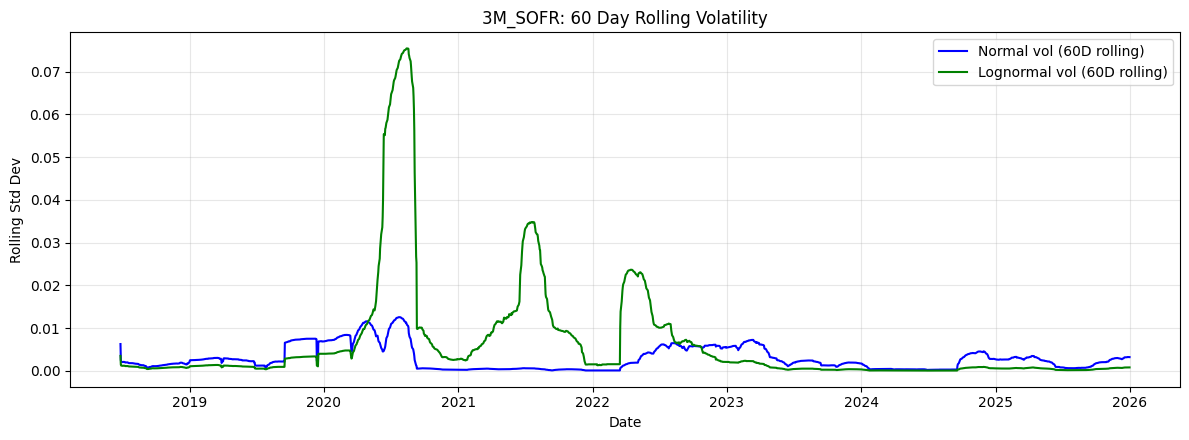

In [9]:
# SOFR rate is non-stationary and mean reverting

# Calculate 60-day rolling volatility of difference in SOFR rates (absolute changes, Normal Vol)
hist_sofr_rates['3M_SOFR_norm_return'] = hist_sofr_rates['3M_SOFR'].diff()
hist_sofr_rates['3M_SOFR_norm_vol'] = hist_sofr_rates['3M_SOFR_norm_return'].rolling(window=60).std()

# Calculate 60-day rolling volatility of log returns (relative changes, Lognormal Vol)
hist_sofr_rates['3M_SOFR_lognorm_return'] = np.log(hist_sofr_rates['3M_SOFR']).diff()
hist_sofr_rates['3M_SOFR_lognorm_vol'] = hist_sofr_rates['3M_SOFR_lognorm_return'].rolling(window=60).std()

# plot SOFR_vol over date
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(hist_sofr_rates['date'], hist_sofr_rates['3M_SOFR_norm_vol'], linewidth=1.5, color='blue', label='Normal vol (60D rolling)')
ax.plot(hist_sofr_rates['date'], hist_sofr_rates['3M_SOFR_lognorm_vol'], linewidth=1.5, color='green', label='Lognormal vol (60D rolling)')

ax.set_title('3M_SOFR: 60 Day Rolling Volatility')
ax.set_xlabel('Date')
ax.set_ylabel('Rolling Std Dev')
ax.grid(True, alpha=0.3)

ax.legend()
plt.tight_layout()
plt.show()

In [10]:
# Value on the date of the option data annualized by sqrt(252) and converted to percentage points
option_data_date = pd.to_datetime('2025-07-29')
vol_on_option_date = hist_sofr_rates.loc[hist_sofr_rates['date'] == option_data_date, ['3M_SOFR_norm_vol', '3M_SOFR_lognorm_vol']]
print(f"3M SOFR Normal Vol on {option_data_date.date()} = {vol_on_option_date['3M_SOFR_norm_vol'].values[0] * np.sqrt(252) * 100:.2f}%")
print(f"3M SOFR Lognormal Vol on {option_data_date.date()} = {vol_on_option_date['3M_SOFR_lognorm_vol'].values[0] * np.sqrt(252) * 100:.2f}%")

3M SOFR Normal Vol on 2025-07-29 = 0.92%
3M SOFR Lognormal Vol on 2025-07-29 = 0.21%


### 1.5.

Plot the open interest across strikes. 

Report the total notional open interest across the chain for this expiration.

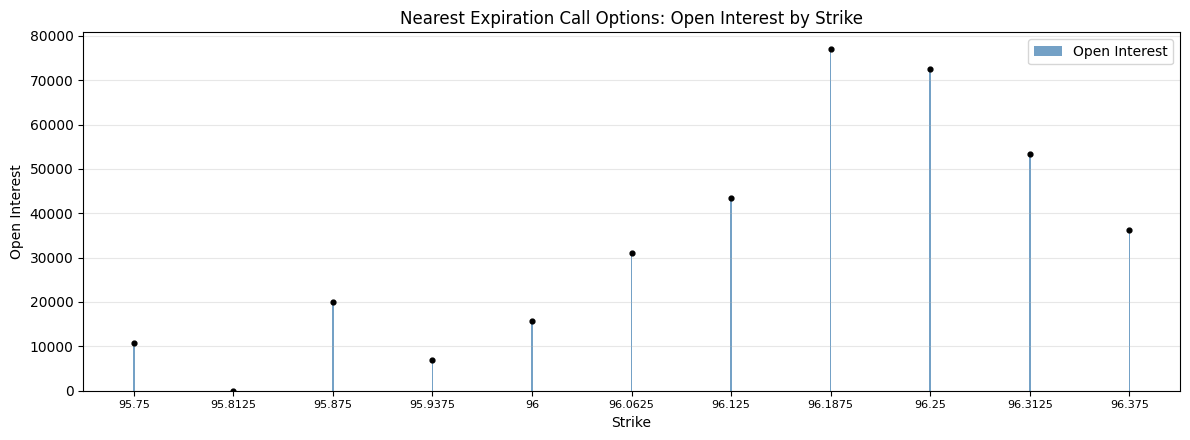

Total open interest (contracts) = 367,060
Total notional proxy (F * OI * Contract Size) = 8,817,240,025.00


In [11]:
# plot open int across strikes

# pick nearest expiry calls
df_oi = (
    call_options_closest_to_exp.copy()
    .loc[:, ['strike price', 'open int', 'bid size', 'ask size']]
    .dropna(subset=['strike price', 'open int', 'bid size', 'ask size'])
    .sort_values('strike price')
)

# ensure numeric
df_oi['open int'] = pd.to_numeric(df_oi['open int'], errors='coerce')
df_oi['bid size'] = pd.to_numeric(df_oi['bid size'], errors='coerce')
df_oi['ask size'] = pd.to_numeric(df_oi['ask size'], errors='coerce')

df_oi = df_oi.dropna(subset=['open int', 'bid size', 'ask size'])

# if multiple rows per strike, aggregate
df_oi = df_oi.groupby('strike price', as_index=False)[['open int', 'bid size', 'ask size']].sum()

# strikes as numeric
x = df_oi['strike price'].astype(float).to_numpy()
y = df_oi['open int'].to_numpy()

# plot
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.bar(x, y, width=0.001, color='steelblue', alpha=0.75, label='Open Interest')
ax.scatter(x, y, color='black', s=12, zorder=3)

ax.set_title('Nearest Expiration Call Options: Open Interest by Strike')
ax.set_xlabel('Strike')
ax.set_ylabel('Open Interest')
ax.grid(True, axis='y', alpha=0.3)

# mark exact strikes on the x-axis
ax.set_xticks(x)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))  # clean numeric labels
ax.tick_params(axis='x', labelsize=8)

ax.legend()
plt.tight_layout()
plt.show()

# totals
total_oi = float(df_oi['open int'].sum())
print(f"Total open interest (contracts) = {total_oi:,.0f}")

# approximate notional OI in "futures price units" (contract multiplier not provided here)
notional_per_contract = float(spot_fut_price)  # rough proxy if you just want F * contracts
total_notional_proxy = total_oi * notional_per_contract * 250 # 250 is the option contract size for these SOFR futures options
print(f"Total notional proxy (F * OI * Contract Size) = {total_notional_proxy:,.2f}")

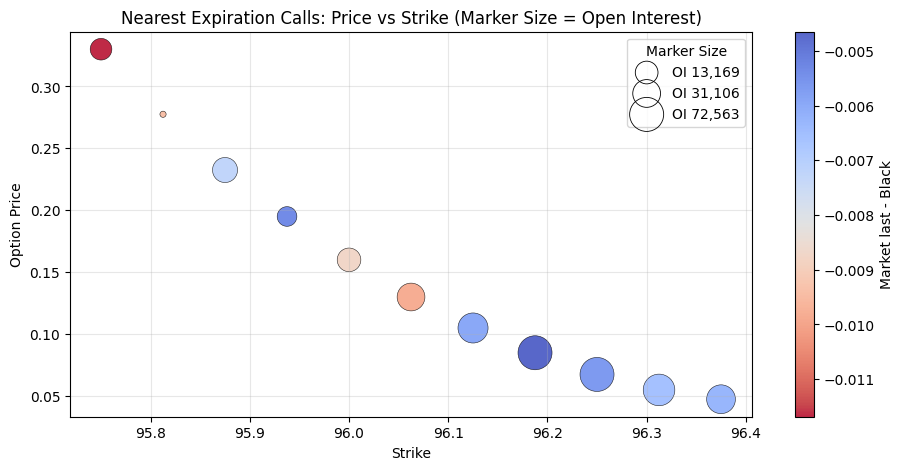

In [12]:
# Build plotting frame for nearest expiry calls
df = (
    call_options_closest_to_exp.copy()
    .loc[:, ['strike price', 'price', 'bid', 'ask', 'open int', 'calc_price']]
    .dropna(subset=['strike price', 'open int'])
    .sort_values('strike price')
)

# Numeric cleanup
df['strike price'] = pd.to_numeric(df['strike price'], errors='coerce')
df['open int'] = pd.to_numeric(df['open int'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['bid'] = pd.to_numeric(df['bid'], errors='coerce')
df['ask'] = pd.to_numeric(df['ask'], errors='coerce')
df['calc_price'] = pd.to_numeric(df['calc_price'], errors='coerce')
df = df.dropna(subset=['strike price', 'open int'])

# Choose y-value: last if available else mid
mid = (df['bid'] + df['ask']) / 2.0
y = df['price'].where(df['price'].notna(), mid)

# Aggregate in case multiple rows per strike
df_plot = (
    pd.DataFrame({
        'strike': df['strike price'],
        'y_price': y,
        'open_int': df['open int'],
        'calc_price': df['calc_price'],
    })
    .groupby('strike', as_index=False)
    .agg({
        'y_price': 'mean',
        'open_int': 'sum',
        'calc_price': 'mean',
    })
    .dropna(subset=['y_price', 'open_int'])
    .sort_values('strike')
)

# Marker sizing (area in points^2): scale by sqrt to reduce domination by large OI
oi = df_plot['open_int'].to_numpy(dtype=float)
oi_ref = np.nanpercentile(oi, 90) if np.isfinite(oi).any() else 1.0
s_min, s_max = 20.0, 600.0
s = s_min + (np.sqrt(np.clip(oi, 0, None)) / np.sqrt(max(oi_ref, 1e-12))) * (s_max - s_min)
s = np.clip(s, s_min, s_max)

# color: Market - Black
color = (df_plot['y_price'] - df_plot['calc_price']).to_numpy(dtype=float)

fig, ax = plt.subplots(figsize=(11, 5))

sc = ax.scatter(
    df_plot['strike'],
    df_plot['y_price'],
    s=s,
    c=color,
    cmap='coolwarm_r',
    alpha=0.85,
    edgecolors='k',
    linewidths=0.4,
)

ax.set_title('Nearest Expiration Calls: Price vs Strike (Marker Size = Open Interest)')
ax.set_xlabel('Strike')
ax.set_ylabel('Option Price')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Market last - Black')

# Simple size legend
legend_oi = [np.nanpercentile(oi, p) for p in (25, 50, 90)]
legend_oi = [v for v in legend_oi if np.isfinite(v)]
handles = [
    ax.scatter([], [], s=float(s_min + (np.sqrt(v) / np.sqrt(max(oi_ref, 1e-12))) * (s_max - s_min)),
               edgecolors='k', facecolors='none', linewidths=0.6)
    for v in legend_oi
]
labels = [f"OI {v:,.0f}" for v in legend_oi]
ax.legend(handles, labels, title='Marker Size', loc='best', frameon=True)

plt.show()

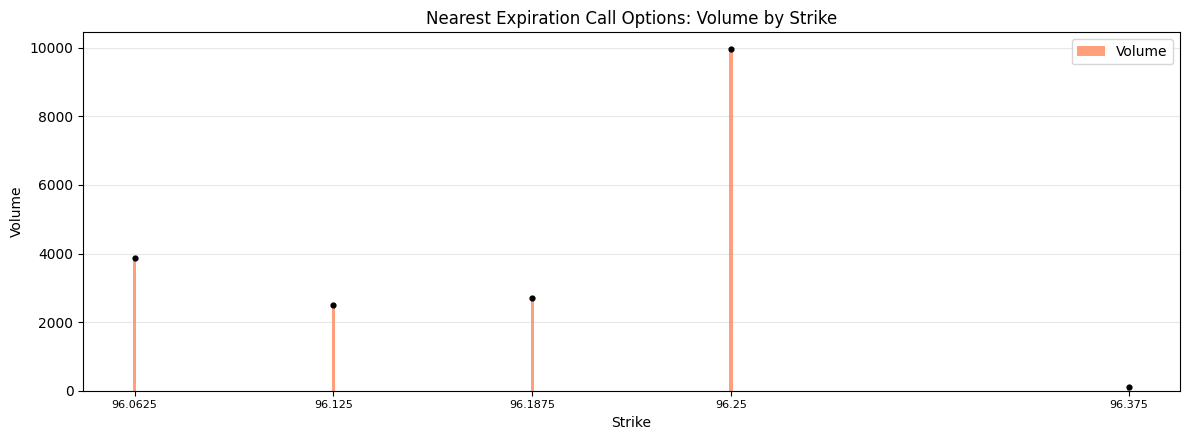

In [13]:
# plot volume across strikes for nearest expiry calls
df_volume = (
    call_options_closest_to_exp.copy()
    .loc[:, ['strike price', 'volume']]
    .dropna(subset=['strike price', 'volume'])
    .sort_values('strike price')
)
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.bar(df_volume['strike price'], df_volume['volume'], width=0.001, color='coral', alpha=0.75, label='Volume')
ax.scatter(df_volume['strike price'], df_volume['volume'], color='black', s=12, zorder=3)
ax.set_title('Nearest Expiration Call Options: Volume by Strike')
ax.set_xlabel('Strike')
ax.set_ylabel('Volume')
ax.grid(True, axis='y', alpha=0.3)
ax.set_xticks(df_volume['strike price'])
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))  # clean numeric labels
ax.tick_params(axis='x', labelsize=8)
ax.legend()
plt.tight_layout()
plt.show()

### Discussion

- The ones having higher divergences between market last and calculated black's price are not-traded as frequently.
- However, there is still noticeable open interest as positions are likely held till expiry.
- Open interest is higher for ITM call options showing that market anticipates rates to fall and future prices to rise.